In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [2]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
merge_df = pd.DataFrame(index = range(5783))

for each in regions:
    df = pd.read_csv('{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)
    df[each] = df[each].fillna(0)
                        
    for i in df.columns:
        df[i] = df[i].fillna(method='ffill')
    
    merge_df = pd.concat([merge_df, df], axis = 1)


In [3]:
merge_df = pd.concat([merge_df[regions], merge_df.drop(columns = regions)], axis =1)
merge_df['Date'] = pd.date_range(start = '2005-01-01', end = '2020-10-31')
merge_df.set_index('Date', inplace=True)

In [4]:
for i in regions:
    merge_df[i] = np.log1p(merge_df[i])

In [6]:
merge_df.head()

,NSW,NT,QL,SA,TA,VI,WA,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,mean_SoilWaterContent_NSW,...,mean_Temperature_VI,mean_WindSpeed_VI,Vegetation_index_mean_VI,mean_Precipitation_WA,mean_RelativeHumidity_WA,mean_SoilWaterContent_WA,mean_SolarRadiation_WA,mean_Temperature_WA,mean_WindSpeed_WA,Vegetation_index_mean_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.0,0.0,0.000000,3.621203,0.044274,36.355567,0.170931,...,17.084568,3.655508,0.430317,1.872415,49.027855,0.075728,26.967495,28.524055,4.201039,0.219956
2005-01-02,0.000000,0.841567,4.181505,0.0,0.0,1.335001,5.004661,0.173879,38.699607,0.169551,...,16.235277,3.260354,0.432169,2.110536,45.840524,0.079449,26.776612,28.695349,4.650767,0.220153
2005-01-03,0.000000,4.496917,3.879223,0.0,0.0,0.693147,4.121185,3.011912,49.365152,0.179981,...,20.105448,4.221786,0.434021,0.851700,39.740976,0.076233,28.656122,27.650498,5.216546,0.220350
2005-01-04,2.270062,0.000000,3.437208,0.0,0.0,0.000000,4.470200,2.808620,57.095628,0.214293,...,16.850386,6.194857,0.435873,0.155206,36.538677,0.067969,29.868001,27.421797,4.850140,0.220547
2005-01-05,2.868538,0.000000,1.609438,0.0,0.0,0.000000,3.477508,0.157935,47.170735,0.203951,...,14.995335,4.807160,0.437724,0.061034,33.564562,0.061579,30.280623,28.159704,4.464719,0.220744


In [128]:
# df.plot(subplots=True);

In [7]:
train = merge_df[:'2019-10-31']
test = merge_df['2019-11-01':'2020-03-02']

In [8]:
test.shape

(123, 56)

In [9]:

tf.keras.backend.clear_session()

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5417, 56)

In [11]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [12]:
n_steps_in, n_steps_out = 365, 123

In [13]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(4930, 123, 7)

In [14]:
X.shape

(4930, 365, 56)

In [15]:
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

In [16]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [17]:
y.shape

(4930, 861)

In [18]:
n_output

861

In [24]:
X_train, y_train = X[:-365,:,:], y[:-365,:]
X_valid, y_valid = X[-365:, :, :], y[-365:, :]

In [25]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss=tf.keras.losses.Huber(), metrics = ['mae'])

In [26]:
history = model.fit(X_train, y_train, epochs = 100, callbacks = [lr_schedule], validation_data = (X_valid, y_valid))

Epoch 1/100
143/143 [==============================] - 14s 99ms/step - loss: 0.0652 - mae: 0.2728 - val_loss: 0.0739 - val_mae: 0.3048
Epoch 2/100
143/143 [==============================] - 11s 78ms/step - loss: 0.0638 - mae: 0.2705 - val_loss: 0.0718 - val_mae: 0.3007
Epoch 3/100
143/143 [==============================] - 11s 78ms/step - loss: 0.0618 - mae: 0.2673 - val_loss: 0.0689 - val_mae: 0.2950
Epoch 4/100
143/143 [==============================] - 11s 77ms/step - loss: 0.0592 - mae: 0.2626 - val_loss: 0.0652 - val_mae: 0.2870
Epoch 5/100
143/143 [==============================] - 11s 78ms/step - loss: 0.0559 - mae: 0.2559 - val_loss: 0.0603 - val_mae: 0.2756
Epoch 6/100
143/143 [==============================] - 11s 77ms/step - loss: 0.0516 - mae: 0.2466 - val_loss: 0.0541 - val_mae: 0.2601
Epoch 7/100
143/143 [==============================] - 11s 78ms/step - loss: 0.0465 - mae: 0.2342 - val_loss: 0.0472 - val_mae: 0.2407
Epoch 8/100
143/143 [==============================] - 

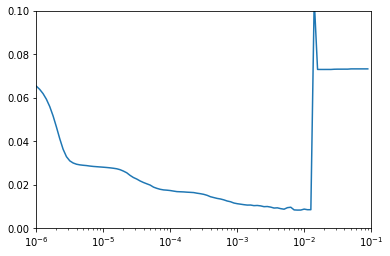

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, .1]);

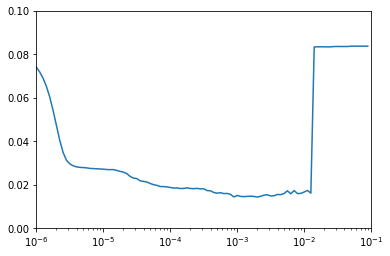

In [28]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, .1]);

In [29]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = 2e-3)


model.compile(optimizer, loss='mean_squared_error', metrics = ['mae'])

In [30]:
history = model.fit(X, y, epochs = 100, validation_split= 0.2)

Epoch 1/100
124/124 [==============================] - 13s 108ms/step - loss: 0.0474 - mae: 0.1473 - val_loss: 0.0352 - val_mae: 0.1313
Epoch 2/100
124/124 [==============================] - 10s 83ms/step - loss: 0.0314 - mae: 0.1200 - val_loss: 0.0353 - val_mae: 0.1338
Epoch 3/100
124/124 [==============================] - 10s 84ms/step - loss: 0.0302 - mae: 0.1180 - val_loss: 0.0328 - val_mae: 0.1284
Epoch 4/100
124/124 [==============================] - 10s 84ms/step - loss: 0.0291 - mae: 0.1161 - val_loss: 0.0342 - val_mae: 0.1326
Epoch 5/100
124/124 [==============================] - 10s 82ms/step - loss: 0.0285 - mae: 0.1155 - val_loss: 0.0338 - val_mae: 0.1317
Epoch 6/100
124/124 [==============================] - 10s 82ms/step - loss: 0.0279 - mae: 0.1144 - val_loss: 0.0322 - val_mae: 0.1290
Epoch 7/100
124/124 [==============================] - 10s 85ms/step - loss: 0.0273 - mae: 0.1133 - val_loss: 0.0337 - val_mae: 0.1314
Epoch 8/100
124/124 [==============================] -

KeyboardInterrupt: 

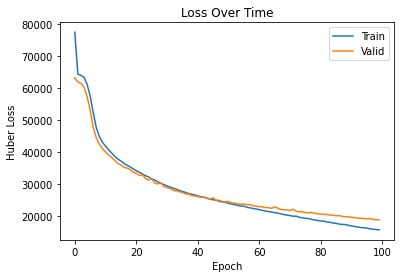

In [220]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [31]:
x_input = np.array(train.iloc[-365:].values)
x_input = scaler.transform(x_input)

In [32]:
x_input = x_input.reshape((1, n_steps_in, n_features))

In [33]:
yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 861)

In [34]:
yhat_df = pd.DataFrame(yhat.reshape(123,7), index = test.index, columns = regions)

In [35]:
yhat_df

,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2019-11-01,0.142769,0.516918,0.711475,0.000000,0.000000,0.000000,0.553028
2019-11-02,0.121227,0.487283,0.678005,0.039282,0.000000,0.000000,0.595706
2019-11-03,0.188926,0.525762,0.698381,0.000000,0.000000,0.000000,0.573223
2019-11-04,0.309731,0.520269,0.666143,0.065522,0.009492,0.000000,0.546962
2019-11-05,0.299555,0.460202,0.695455,0.064397,0.000000,0.000000,0.601113
...,...,...,...,...,...,...,...
2020-02-27,0.355895,0.000000,0.157021,0.107545,0.025405,0.000000,0.361510
2020-02-28,0.369880,0.000000,0.179297,0.000000,0.000000,0.000000,0.341459
2020-02-29,0.344584,0.027444,0.166846,0.000000,0.062066,0.000000,0.300022


In [36]:
for i in range(49):
    yhat_df['dummy_{}'.format(i)] = 0

In [37]:
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [38]:
yhat_df

,NSW,NT,QL,SA,TA,VI,WA,dummy_0,dummy_1,dummy_2,...,dummy_39,dummy_40,dummy_41,dummy_42,dummy_43,dummy_44,dummy_45,dummy_46,dummy_47,dummy_48
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,1.089244,4.767260,5.882936,0.000000,0.000000,0.000000,5.000584,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
2019-11-02,0.924895,4.493944,5.606179,0.291238,0.000000,0.000000,5.386484,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
2019-11-03,1.441397,4.848816,5.774668,0.000000,0.000000,0.000000,5.183196,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
2019-11-04,2.363074,4.798163,5.508102,0.485775,0.063787,0.000000,4.945735,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
2019-11-05,2.285435,4.244192,5.750474,0.477434,0.000000,0.000000,5.435383,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,2.715279,0.000000,1.298350,0.797330,0.170718,0.000000,3.268847,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
2020-02-28,2.821970,0.000000,1.482539,0.000000,0.000000,0.000000,3.087539,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375
2020-02-29,2.628983,0.253104,1.379591,0.000000,0.417080,0.000000,2.712854,0.0,22.725358,0.134667,...,3.882784,1.021881,0.362486,0.0,16.943452,0.043158,7.075281,10.353483,2.190281,0.198375


In [39]:
test

,NSW,NT,QL,SA,TA,VI,WA,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,mean_SoilWaterContent_NSW,...,mean_Temperature_VI,mean_WindSpeed_VI,Vegetation_index_mean_VI,mean_Precipitation_WA,mean_RelativeHumidity_WA,mean_SoilWaterContent_WA,mean_SolarRadiation_WA,mean_Temperature_WA,mean_WindSpeed_WA,Vegetation_index_mean_WA
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,4.846807,4.239465,3.238959,0.000000,0.000000,0.000000,4.852502,0.646422,39.618650,0.142438,...,22.690870,4.307983,0.499104,0.457273,36.966465,0.053248,25.494077,22.322727,5.612717,0.198147
2019-11-02,4.389342,4.648187,3.725954,2.533470,0.000000,0.000000,5.509735,6.345006,60.935982,0.181463,...,15.738659,2.674326,0.496327,0.063733,32.815531,0.051577,27.091837,22.311709,4.968022,0.198231
2019-11-03,2.706048,3.830478,3.785068,1.736951,0.000000,0.000000,6.022385,10.946352,78.123328,0.273575,...,13.070452,3.481689,0.493549,0.006073,26.776553,0.048556,29.579690,24.057580,4.511903,0.198316
2019-11-04,4.694175,2.434709,3.858746,0.000000,0.000000,0.000000,6.754943,0.807121,56.413287,0.263677,...,9.632857,3.983539,0.490772,0.026830,22.723658,0.045922,30.111122,26.328552,4.661652,0.198400
2019-11-05,3.910865,3.183230,4.150352,3.079614,0.000000,0.000000,6.855914,0.144822,47.964062,0.237052,...,13.352102,3.780528,0.487995,0.049837,23.844331,0.043632,29.776592,26.910117,4.336380,0.198485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,2.187335,0.000000,0.887891,0.000000,0.000000,0.000000,3.003328,0.505206,45.087274,0.207770,...,15.821205,4.305432,0.474408,1.362781,44.028823,0.073723,24.276483,30.420047,5.539308,0.247215
2020-02-28,1.873032,0.000000,2.331496,0.000000,0.693147,1.458615,0.000000,0.178557,48.498570,0.196893,...,16.114877,2.575523,0.476233,4.797984,43.627956,0.085919,22.710582,30.326393,5.191722,0.247510
2020-02-29,2.639057,0.000000,3.177845,0.000000,0.000000,1.472472,0.000000,0.054360,47.417610,0.188808,...,18.760250,2.117036,0.478059,7.337296,49.448563,0.100181,20.589635,29.665557,5.248466,0.247804


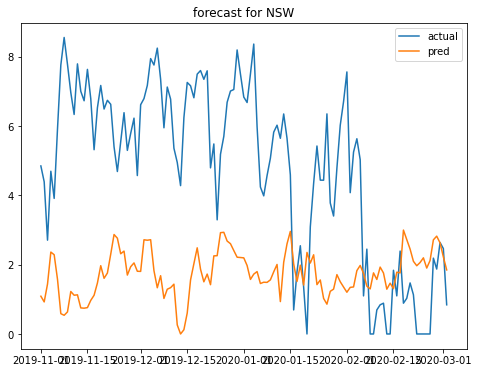

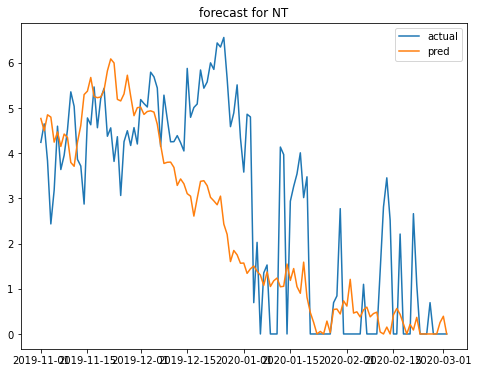

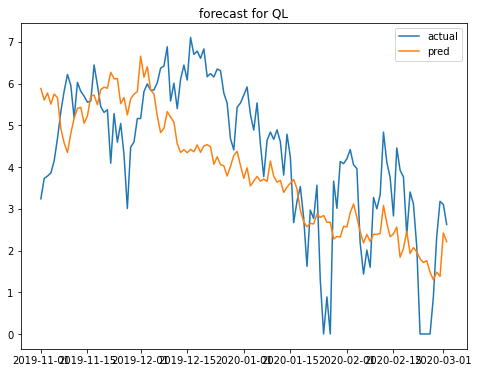

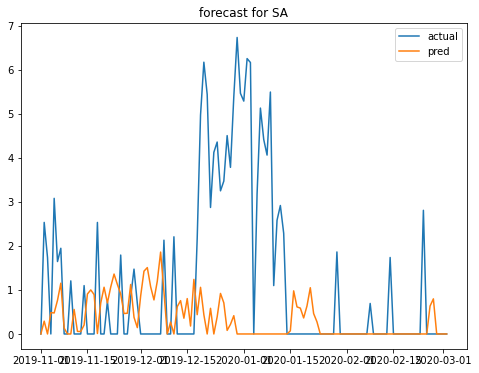

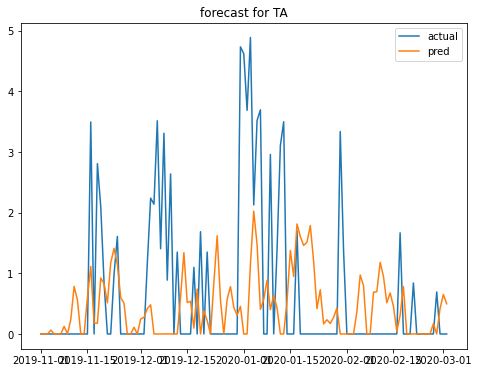

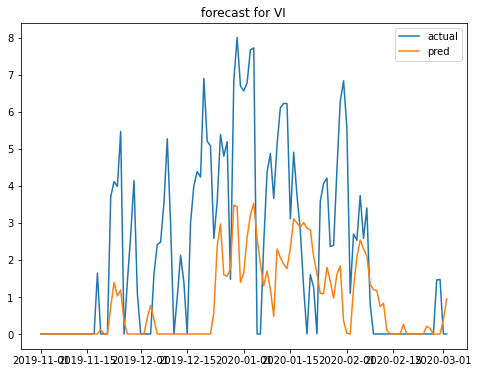

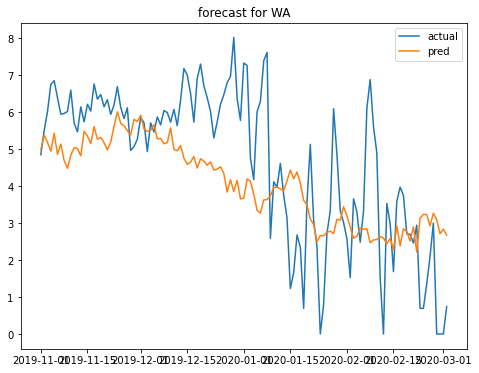

In [40]:
for i in regions:

    plt.figure(figsize=(8,6))
    plt.plot(test[:'2020-03'][i], label = 'actual')
    plt.plot(yhat_df[:'2020-03'][i], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

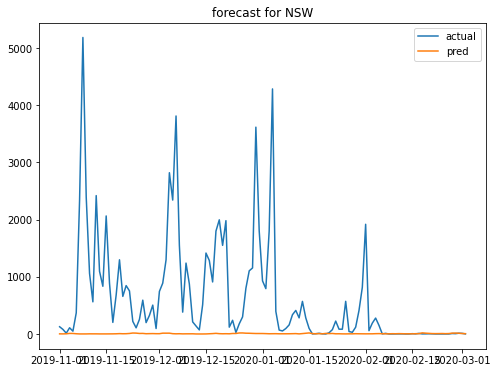

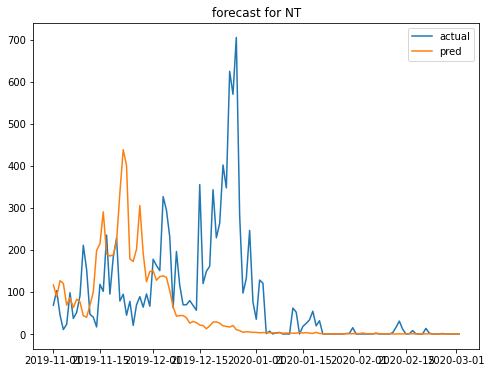

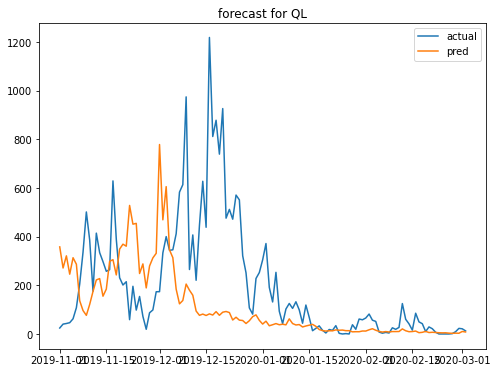

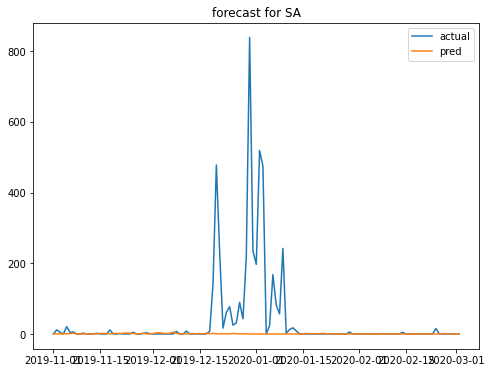

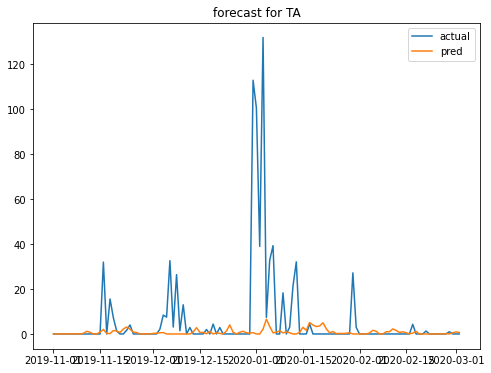

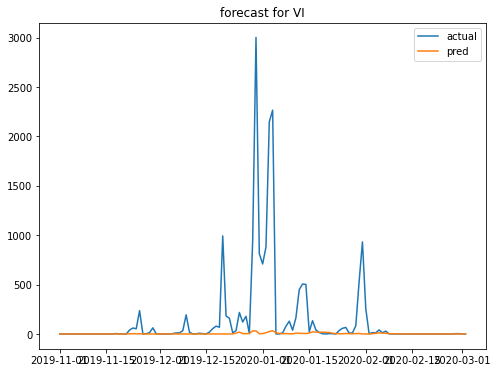

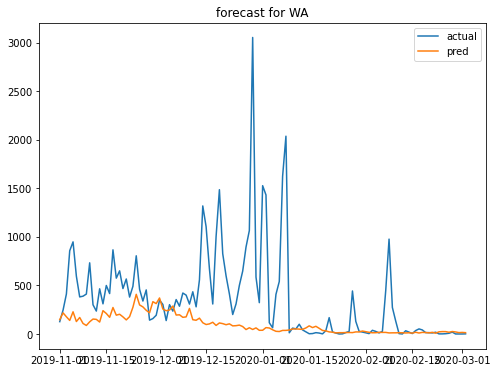

In [41]:
for i in regions:

    plt.figure(figsize=(8,6))
    plt.plot(np.exp(test[:'2020-03'][i]) - 1, label = 'actual')
    plt.plot(np.exp(yhat_df[:'2020-03'][i]) - 1, label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = (np.exp(yhat_df['2020-02':][regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][regions].values)-1).flatten())

mse = mean_squared_error(y_true = (np.exp(yhat_df['2020-02':][regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][regions].values)-1).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}

In [45]:
_results

{'dcnn_log1p': {'mae': 27.935948853070276, 'mse': 23578.32271703908}}